In [22]:
!pip install panda
!pip install matplotlib
!pip install seaborn
!pip install scipy --user

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Looking in links: /usr/share/pip-wheels


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway, pearsonr, spearmanr

In [56]:
# Load data
csat = pd.read_csv("csat_data.csv", index_col="response_date", parse_dates=True)
audit = pd.read_csv("self_audit_data.csv", index_col="date", parse_dates=True)

In [61]:
# Merge for aligned metrics
merged = pd.merge(
    audit.reset_index().rename(columns={'date': 'merge_date'}),
    csat.reset_index().rename(columns={'response_date': 'merge_date'}),
    on=['merge_date', 'agent_name'],
    how='inner'
)

In [58]:
csat['period'] = csat.index >= audit.index.min()
pre_scores = csat.loc[csat['period'] == False, 'csat_count']
post_scores = csat.loc[csat['period'] == True, 'csat_count']


In [62]:
print("CSAT Data:", csat.shape)
print("Audit Data:", audit.shape)
print("CSAT Date Range:", csat.index.min(), "to", csat.index.max())
print("Audit Date Range:", audit.index.min(), "to", audit.index.max())

CSAT Data: (4395, 16)
Audit Data: (117, 13)
CSAT Date Range: 2024-01-01 00:00:00 to 2024-09-16 00:00:00
Audit Date Range: 2024-03-08 00:00:00 to 2024-09-06 00:00:00


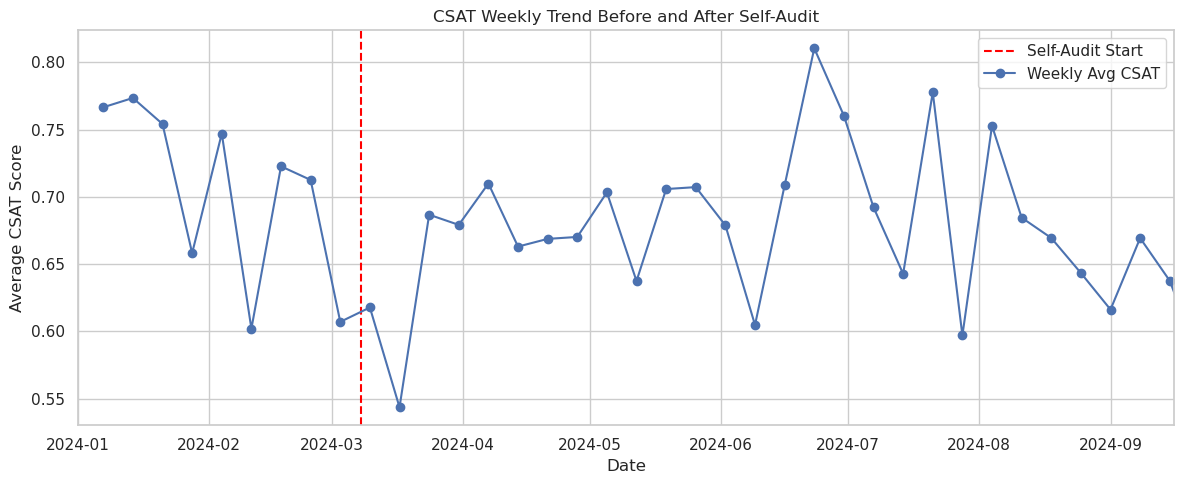

In [63]:
csat_weekly = csat['csat_count'].resample('W').mean()
audit_start = audit.index.min()

plt.figure(figsize=(12,5))
plt.axvline(audit_start, color='red', linestyle='--', label='Self-Audit Start')
plt.plot(csat_weekly, label='Weekly Avg CSAT', marker='o')
plt.title('CSAT Weekly Trend Before and After Self-Audit')
plt.ylabel('Average CSAT Score')
plt.xlabel('Date')
plt.xlim(csat.index.min(), csat.index.max()) 
plt.legend()
plt.tight_layout()
plt.show()


In [64]:
# 1. Impact Assessment
print("1. Impact Assessment: CSAT before vs after self-assessment")
pre_mean = pre_scores.mean()
post_mean = post_scores.mean()
stat, p_value = ttest_ind(post_scores, pre_scores, equal_var=False)
print(f"Pre-CSAT mean: {pre_mean:.3f}, Post-CSAT mean: {post_mean:.3f}")
print(f"T-test statistic: {stat:.3f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: Statistically significant increase in CSAT after self-audit.")
else:
    print("Result: No statistically significant change in CSAT after self-audit.")

1. Impact Assessment: CSAT before vs after self-assessment
Pre-CSAT mean: 0.698, Post-CSAT mean: 0.675
T-test statistic: -1.334, p-value: 0.1824
Result: No statistically significant change in CSAT after self-audit.


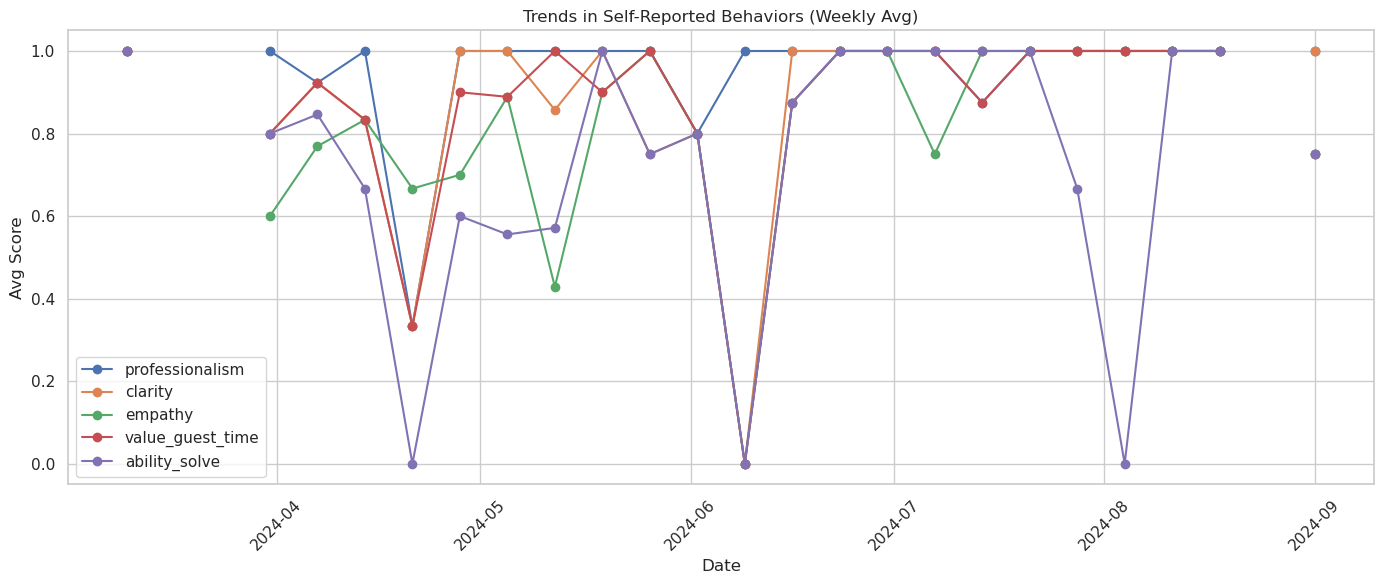

In [65]:
# 2. Behavioral Trends (fixed)
behavior_cols = ['professionalism', 'clarity', 'empathy', 'value_guest_time', 'ability_solve']
audit_weekly = audit[behavior_cols].resample('W-SUN').mean()

# Reindex to ensure all weeks are shown including March
audit_full_range = pd.date_range(start=audit.index.min().floor('D'), end=audit.index.max(), freq='W-SUN')
audit_weekly = audit_weekly.reindex(audit_full_range)

plt.figure(figsize=(14, 6))
for col in behavior_cols:
    plt.plot(audit_weekly.index, audit_weekly[col], label=col, marker='o')

plt.title('Trends in Self-Reported Behaviors (Weekly Avg)')
plt.xlabel('Date')
plt.ylabel('Avg Score')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



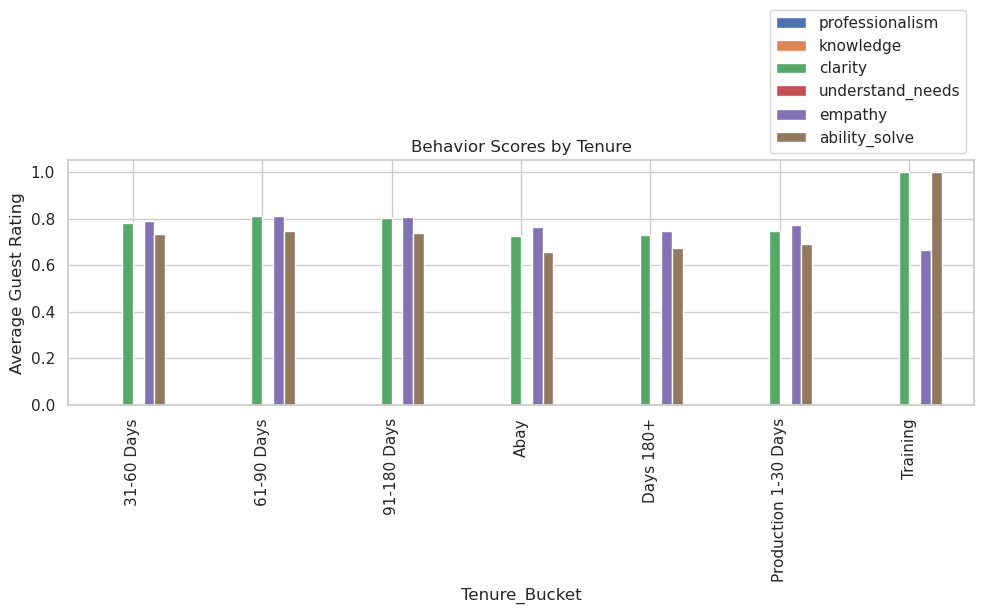

In [84]:
# 3. Tenure vs. Proficiency
tenure_behavior = csat.groupby('Tenure_Bucket')[['professionalism', 'knowledge', 'clarity', 'understand_needs', 'empathy', 'ability_solve']].mean()
tenure_behavior.plot(kind='bar', figsize=(10, 5))
plt.title('Behavior Scores by Tenure')
plt.ylabel('Average Guest Rating')
plt.tight_layout()
plt.legend(loc='lower right',bbox_to_anchor=(1, 1))
plt.show()

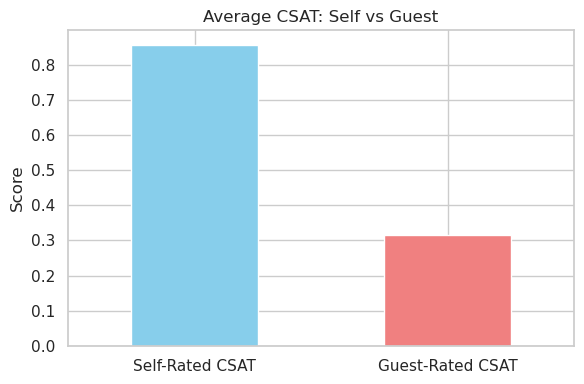

In [86]:
4#turn this one into a weekly comparison from the start date and add the  Csat
self_vs_actual = audit[['self_csat', 'csat_count']].mean()
self_vs_actual.plot(kind='bar', figsize=(6,4), color=['skyblue','lightcoral'])
plt.xticks([0,1], ['Self-Rated CSAT','Guest-Rated CSAT'], rotation=0)
plt.title('Average CSAT: Self vs Guest')
plt.ylabel('Score')
plt.tight_layout()
plt.show()    

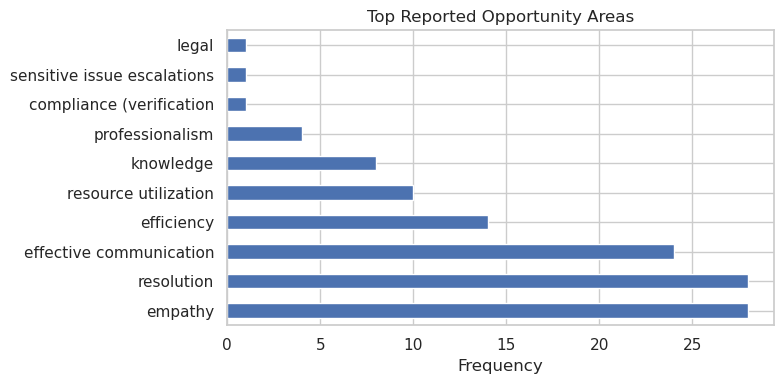

In [87]:
# 5. Pre vs Post Comparison
opp_text = audit['opportunities'].dropna().str.lower().str.split(',')
opp_flat = pd.Series([i.strip() for sub in opp_text for i in sub])
top_opps = opp_flat.value_counts().head(10)

plt.figure(figsize=(8,4))
top_opps.plot(kind='barh')
plt.title('Top Reported Opportunity Areas')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [80]:
# 6. Pre vs Post Breakdown by Behavior
print("\n6. Pre vs Post by CSAT category")
for col in behavior_cols:
    before = csat.loc[csat['period'] == False, col].mean()
    after = csat.loc[csat['period'] == True, col].mean()
    print(f"{col}: Pre = {before:.3f}, Post = {after:.3f}")


6. Pre vs Post by CSAT category
professionalism: Pre = 0.000, Post = 0.000
clarity: Pre = 0.765, Post = 0.750
empathy: Pre = 0.772, Post = 0.767
ability_solve: Pre = 0.704, Post = 0.694


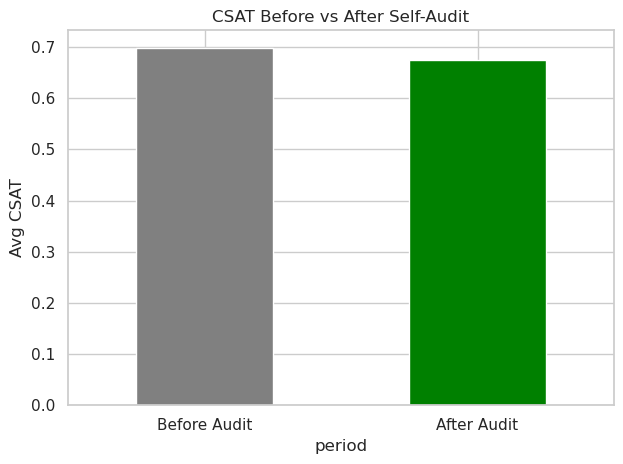

In [88]:
# 6. Pre vs Post Breakdown by Behavior
csat['period'] = csat.index >= audit_start
pre_post = csat.groupby('period')['csat_count'].mean()
pre_post.plot(kind='bar', color=['gray','green'])
plt.xticks([0,1], ['Before Audit','After Audit'], rotation=0)
plt.ylabel('Avg CSAT')
plt.title('CSAT Before vs After Self-Audit')
plt.tight_layout()
plt.show()
